In [1]:
# To make debugging of multilayer_perceptron module easier we enable imported modules autoreloading feature.
# By doing this you may change the code of multilayer_perceptron library and all these changes will be available here.
%load_ext autoreload
%autoreload 2

# Add project root folder to module loading paths.
import sys
sys.path.append('../..')

### Import Dependencies

- [pandas](https://pandas.pydata.org/) - library that we will use for loading and displaying the data in a table
- [numpy](http://www.numpy.org/) - library that we will use for linear algebra operations
- [matplotlib](https://matplotlib.org/) - library that we will use for plotting the data
- [math](https://docs.python.org/3/library/math.html) - math library that we will use to calculate sqaure roots etc.
- [neural_network](https://github.com/trekhleb/homemade-machine-learning/blob/master/homemade/neural_network/multilayer_perceptron.py) - custom implementation of multilayer perceptron

In [2]:
# Import 3rd party dependencies.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# Import custom multilayer perceptron implementation.
from homemade.neural_network import MultilayerPerceptron

### Load the Data

In this demo we will be using a sample of [MNIST dataset in a CSV format](https://www.kaggle.com/oddrationale/mnist-in-csv/home). Instead of using full dataset with 60000 training examples we will use cut dataset of just 10000 examples that we will also split into training and testing sets.

Each row in the dataset consists of 785 values: the first value is the label (a number from 0 to 9) and the remaining 784 values (28x28 pixels image) are the pixel values (a number from 0 to 255).

In [3]:
# Load the data.
data = pd.read_csv('../../data/mnist-demo.csv')

# Print the data table.
data.head(10)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Plot the Data

Let's peek first 25 rows of the dataset and display them as an images to have an example of digits we will be working with.

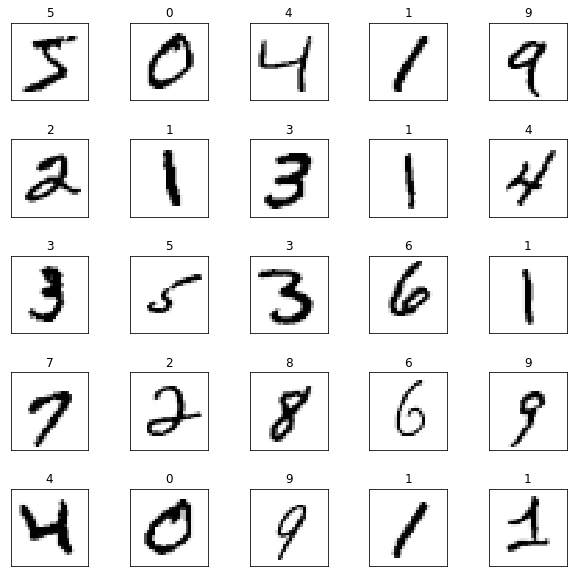

In [4]:
# How many numbers to display.
numbers_to_display = 25

# Calculate the number of cells that will hold all the numbers.
num_cells = math.ceil(math.sqrt(numbers_to_display))

# Make the plot a little bit bigger than default one.
plt.figure(figsize=(10, 10))

# Go through the first numbers in a training set and plot them.
for plot_index in range(numbers_to_display):
    # Extrace digit data.
    digit = data[plot_index:plot_index + 1].values
    digit_label = digit[0][0]
    digit_pixels = digit[0][1:]

    # Calculate image size (remember that each picture has square proportions).
    image_size = int(math.sqrt(digit_pixels.shape[0]))
    
    # Convert image vector into the matrix of pixels.
    frame = digit_pixels.reshape((image_size, image_size))
    
    # Plot the number matrix.
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(frame, cmap='Greys')
    plt.title(digit_label)
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Plot all subplots.
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### Split the Data Into Training and Test Sets

In this step we will split our dataset into _training_ and _testing_ subsets (in proportion 80/20%).

Training data set will be used for training of our model. Testing dataset will be used for validating of the model. All data from testing dataset will be new to model and we may check how accurate are model predictions.

In [5]:
# Split data set on training and test sets with proportions 80/20.
# Function sample() returns a random sample of items.
pd_train_data = data.sample(frac=0.8)
pd_test_data = data.drop(pd_train_data.index)

# Convert training and testing data from Pandas to NumPy format.
train_data = pd_train_data.values
test_data = pd_test_data.values

# Extract training/test labels and features.
num_training_examples = 10
x_train = train_data[:num_training_examples, 1:]
y_train = train_data[:num_training_examples, [0]]

x_test = test_data[:, 1:]
y_test = test_data[:, [0]]

In [45]:
# Configure neural network.
layers = [
    784, # Input layer - 28x28 input pixels.
    25,  # First hidden layer - 25 hidden units.
    10,  # Output layer - 10 labels, from 0 to 9.
];
epsilon = 0.12  # Defines the range for initial theta values.
max_iterations = 1000  # Max number of gradient descent iterations.
regularization_param = 0  # Helps to fight model overfitting. 

# Init neural network.
multilayer_perceptron = MultilayerPerceptron(x_train, y_train, layers, epsilon)

# Train neural network.
(thetas, costs) = multilayer_perceptron.train(regularization_param, max_iterations)

{0: array([[-0.0758517 , -0.10922462,  0.03927368, ..., -0.10116138,
        -0.06562225,  0.08434671],
       [ 0.0605631 ,  0.07263726, -0.02723178, ..., -0.11961522,
         0.11282753, -0.02994306],
       [ 0.11871606,  0.07256746, -0.01404285, ...,  0.10602606,
         0.10491185, -0.05867995],
       ...,
       [ 0.0919954 , -0.04510364,  0.03600806, ...,  0.11729077,
        -0.05894698,  0.06732849],
       [-0.11695147,  0.10688355,  0.0685417 , ..., -0.03359375,
        -0.0944231 ,  0.05190055],
       [-0.01826086,  0.09777763,  0.08879194, ...,  0.0213223 ,
        -0.01198016,  0.08821151]]), 1: array([[-0.0758517 , -0.10922462,  0.03927368,  0.04616654, -0.03550035,
        -0.04301836, -0.05111002, -0.01779515,  0.01221125,  0.01600122,
        -0.07813955, -0.04786295,  0.08427782,  0.09664291,  0.02393845,
        -0.11691394, -0.09485863,  0.10624724,  0.04490283, -0.10627072,
         0.10434709,  0.09732701,  0.00282358, -0.00734285, -0.09995941,
        -0.114